In [161]:
import os
import imageio
import cv2
import numpy as np
import nibabel as nib 
import matplotlib.pylab as plt 
from PIL import Image

import torch
from torchvision import transforms

### Auxiliary Functions 

In [208]:
def PercentileRescaler(Arr):
    minval=np.percentile(Arr, 0, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)
    maxval=np.percentile(Arr, 100, axis=None, out=None, overwrite_input=False, interpolation='linear', keepdims=False)

    if minval==maxval:
        print("Zero Detected")
    Arr=(Arr-minval)/(maxval-minval)
    Arr=np.clip(Arr, 0.0, 1.0)
    return Arr, minval, maxval

def RestoreRescaler (Arr, minval, maxval):
    arr= Arr*(maxval-minval)+(minval)
    arr = np.clip(arr, minval, maxval)
    return arr

def load_sample_dicom():
        
    import glob 
    import pydicom 

    dicom_paths = sorted(glob.glob('/mnt/alp/Research Data Sets/TemporalResolutionEnhancement/datasets_prospective/dicoms/YYY/series55001-Body/*'))

    dicoms = [pydicom.read_file(dicom_path) for dicom_path in dicom_paths]

    pixel_arrays = read_dicoms(dicoms)

    return dicoms, pixel_arrays, dicom_paths

def read_dicoms(dicoms):

    import numpy as np 
    
    pixel_arrays = None
    for dicom in dicoms: 
        pixel_array  = dicom.pixel_array 

        if pixel_arrays is None:
            pixel_arrays = pixel_array[None]
        else:
            pixel_arrays = np.concatenate((pixel_arrays, pixel_array[None]))

    return pixel_arrays 


def generate_gif(data, filename='./samples/im'):
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    writer = imageio.get_writer(filename+'.gif', fps=15)
    n_phases, ny, nz = data.shape
    for phase_id in range(n_phases):

        image, minval, maxval = PercentileRescaler(data[phase_id])
        image = (255*image).astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        writer.append_data(image)
        
    writer.close()

### Load and Display Data 

In [154]:
# load phases from a single slice 
dicoms, pixel_arrays, dicom_paths= load_sample_dicom()
nt, nx, ny = pixel_arrays.shape 

(25, 384, 384)

In [163]:
generate_gif(pixel_arrays, filename='./samples/im')

<img src='./samples/im.gif' width="250" align="center">

#### Load and Prepare Model 

In [6]:
os.environ["CUDA_VISIBLE_DEVICES"]='1'

device = torch.device('cuda')

from model.VFIT_B_Deformation import UNet_3D_3D

model = UNet_3D_3D(n_inputs=4, joinType="concat")

model = torch.nn.DataParallel(model).to(device)

print("#params" , sum([p.numel() for p in model.parameters()]))


#params 29082065


In [7]:
load_from = '/mnt/alp/Users/Manuel/code/Video-Frame-Interpolation-Transformer/checkpoints_large_dataset_2022_10_03/model_best.pth'
model_dict = model.state_dict()
model.load_state_dict(torch.load(load_from)["state_dict"] , strict=True)
model.eval();

### Test Model: Twofold DENT Interpolation 

In [209]:
def apply_dent_to_cine(pixel_arrays):

    T = transforms.Compose([transforms.ToTensor()])

    with torch.no_grad():

        interpolated = None 
        original     = None 
        for center_phase_idx in range(len(pixel_arrays)):

            if center_phase_idx < len(pixel_arrays) - 1:
                sample_ids = [center_phase_idx-2, center_phase_idx-1, center_phase_idx, center_phase_idx+1]
            else:
                sample_ids = [center_phase_idx-2, center_phase_idx-1, center_phase_idx, 0]

            # the model was trained using 16-bit images extracted from the DICOM 
            # they were then 0-1 normalized. Here we perform equivalent operation:
            samples, minval, maxval = PercentileRescaler(pixel_arrays[np.array(sample_ids)]) # normalize 16-bit array to 0-1

            # the training data was extracted as .png to enable visualization, which requires cv2 
            # here we avoid the use of the cv2 module (can be painful to install), and simply simulate RBG image 
            # (not ideal, we could-retrain model in a better way to avoid these operations)
            samples = (255*np.repeat(samples[...,None], 3, -1)).astype('uint8') 

            # Now we loop frame-by-brame. This could be parallelize, but for now assume batch = 1 
            images = [T(samples[tk])[None] for tk in range(4)]
            images = [img.cuda() for img in images]

            torch.cuda.synchronize()
            
            # let's run the model. We won't focus on the deformation for now. 
            out, deformation = model(images) # interpolate image at t + 0.5
            out = np.clip(out.detach().cpu().numpy(), 0, 1)
            out = RestoreRescaler(out, minval, maxval)

            prev_phase = pixel_arrays[center_phase_idx-1][None]
            next_phase_interpolated = out[:,0]
            
            if interpolated is None:
                original     = prev_phase
                interpolated = next_phase_interpolated
            else:
                original     = np.concatenate((original, prev_phase))
                interpolated = np.concatenate((interpolated, next_phase_interpolated))
            torch.cuda.synchronize()

    return original, interpolated

#### Twofold Interpolation

In [220]:
original, interpolated = apply_dent_to_cine(pixel_arrays)

/home/mmorales/miniconda3/envs/DL2/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


The `original` array has all the original input phases. The `interpolated` array has the new interpolated phases. Let's combine them 

In [222]:
original_cine = np.zeros((nt*2,nx,ny), dtype=original.dtype)
twofold_cine  = np.zeros((nt*2,nx,ny), dtype=original.dtype)

In [223]:
# repeat every other frame 
original_cine[::2]  = pixel_arrays 
original_cine[1::2] = pixel_arrays 
# insert a new phase in-between 
twofold_cine[::2]  = original 
twofold_cine[1::2] = interpolated 

combined = np.concatenate((original_cine, twofold_cine), axis=2)

In [224]:
generate_gif(combined, filename='./samples/dent_twofold')

<img src='./samples/dent_twofold.gif' width="250" align="center">


#### Fourfold Interpolation

In [225]:
original2, interpolated2 = apply_dent_to_cine(twofold_cine)

In [226]:
original_cine2 = np.zeros((nt*4,nx,ny), dtype=original2.dtype)
twofold_cine2  = np.zeros((nt*4,nx,ny), dtype=original2.dtype)

In [227]:
# repeat every other 4 phases 
original_cine2[0::4] = pixel_arrays 
original_cine2[1::4] = pixel_arrays 
original_cine2[2::4] = pixel_arrays 
original_cine2[3::4] = pixel_arrays 
# insert a new phase in-between 
twofold_cine2[0::2] = original2 
twofold_cine2[1::2] = interpolated2 

combined = np.concatenate((original_cine2, twofold_cine2), axis=2)

In [228]:
generate_gif(combined, filename='./samples/dent_fourfold')

<img src='./samples/dent_twofold.gif' width="250" align="center">

Not sure if the difference between the two is well visualized here. Feel free to open the corresponding .gif files manually and compare the difference between original and interpolated cines. After making sure we're confident the network is working as expected, we can then move on to extract the motion fields 

### Deformation Fields 


Given as input four cardiac cine phases $x_\tau$, where $\tau = t-\Delta t, t, t + \Delta t, t + \Delta 2t$ and $\Delta t$ is the temporal spacing between phases, a new phase $x_{t+\Delta t}$ is synthesized in-between. The phase is generated as follows:


$ x_{t+\Delta t}(p) = \sum_{\tau} B_\tau \sum_{k}w_{\tau}^{k}x_\tau (p + u_{\tau}^k(p)) \hspace{1 cm}\forall p\in\Omega$

where $p$ is pixel, $u$ are deformation vectors, $w$ are kernel weights that scale the contribution of each vector, and $B$ is a blending mask. 

Since $u_{\tau}^k (p)$ non-integer valued, the term $x_\tau (p + u_{\tau}^k(p))$ is evaluated using linear interpolation. 

In [229]:
fstart = 0
fspacing = 2
sample_ids = [fstart + fspacing*(j-2) for j in range(4)]
print(sample_ids)

[-4, -2, 0, 2]


In [231]:
z_slice = 5

data = pixel_arrays.copy()

T = transforms.Compose([transforms.ToTensor()])

fstart = 0
fspacing = 8
sample_ids = [fstart + fspacing*j for j in range(4)]
print(sample_ids)
samples, minval, maxval = PercentileRescaler(data[np.array(sample_ids)])

samples = (255*np.repeat(samples[...,None], 3, -1)).astype('uint8') 

# Now we loop frame-by-brame. This could be parallelize, but for now assume batch = 1 
images = [T(samples[tk])[None] for tk in range(4)]
images = [img.cuda() for img in images]

torch.cuda.synchronize()

out, deformation = model(images) # interpolate image at t + 0.5

out = np.clip(out.detach().cpu().numpy(), 0, 1)
out = RestoreRescaler(out, minval, maxval)

weights, alphas, betas, Occlusion = deformation

dx = alphas.detach().cpu().numpy()
dy = betas.detach().cpu().numpy()
w  = weights.detach().cpu().numpy()
B  = Occlusion.detach().cpu().numpy()

[0, 8, 16, 24]


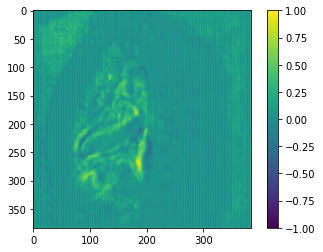

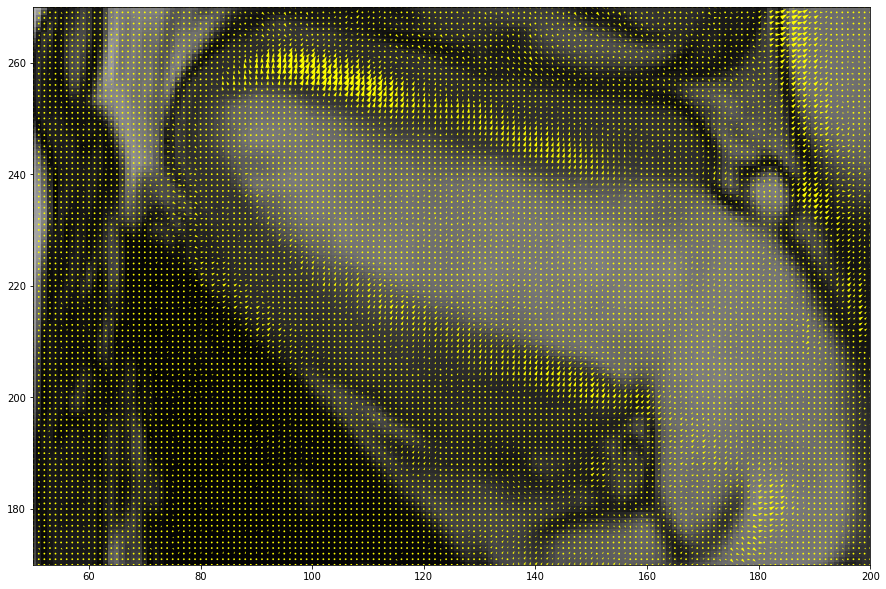

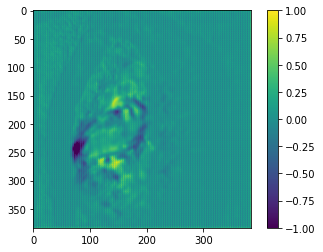

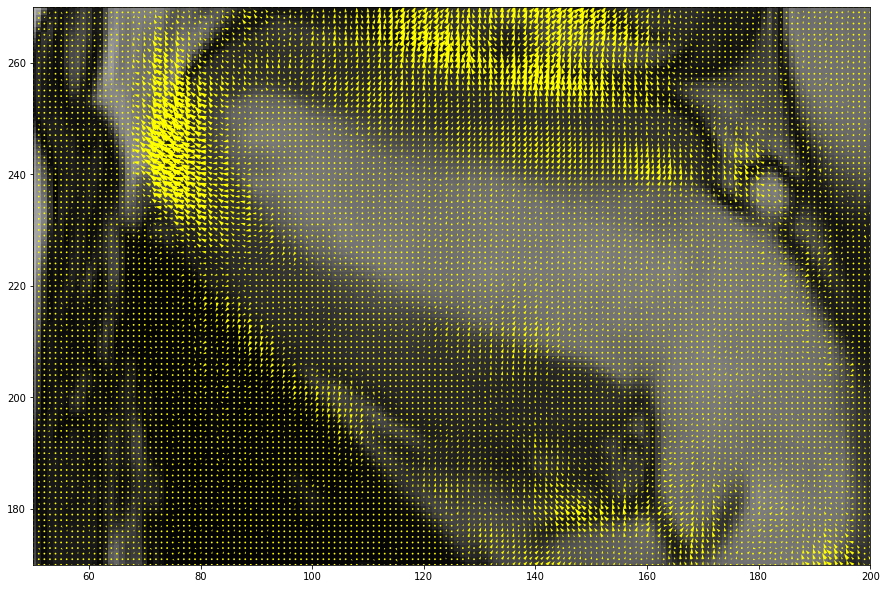

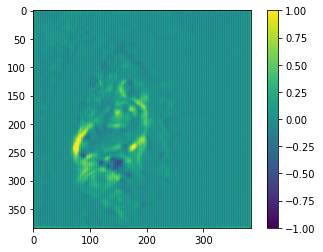

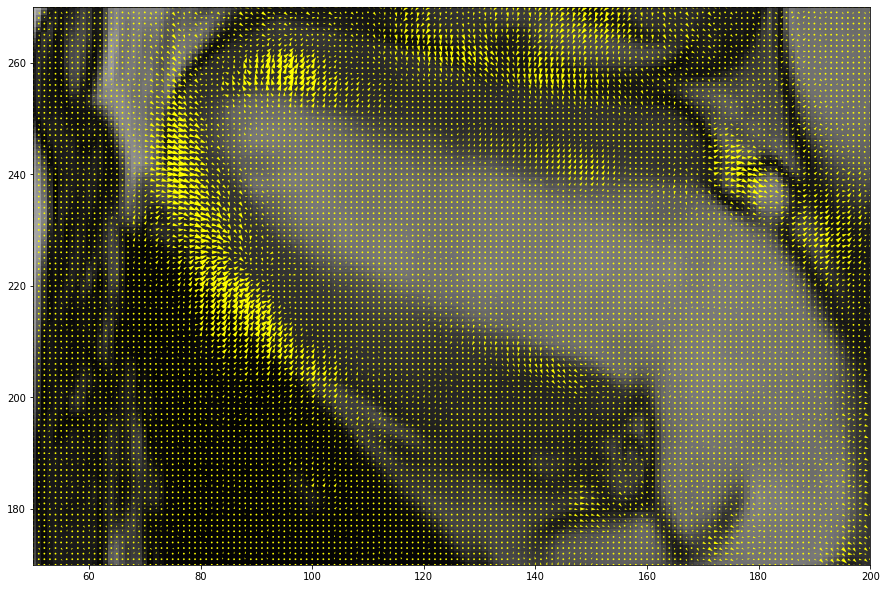

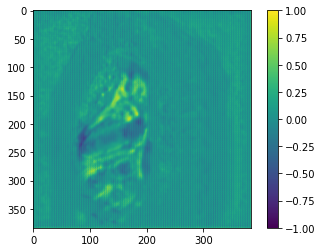

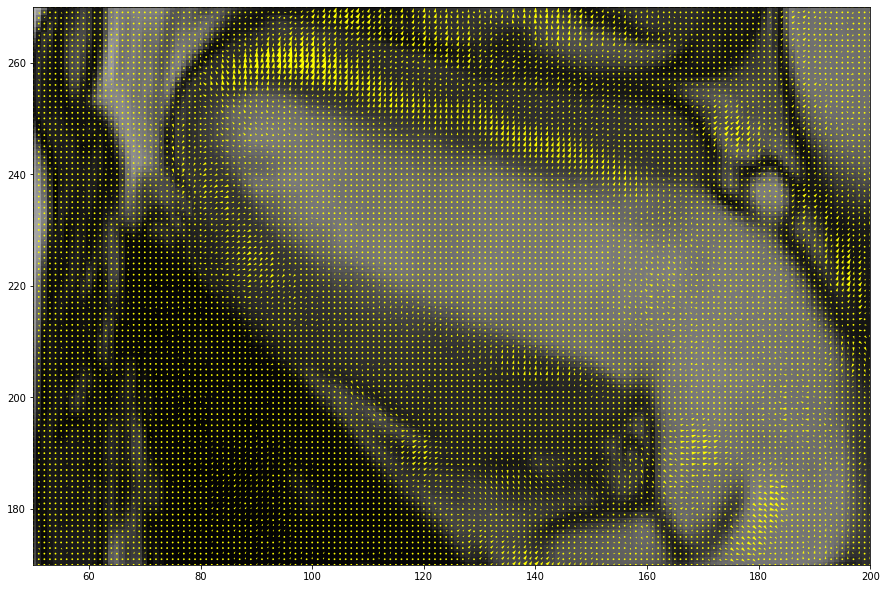

In [232]:
K = dx.shape[2]
for frame_id in range(4):
        
    mean_ux = np.stack([w[0,frame_id,k] * dx[0,frame_id,k] for k in range(K)])
    mean_uy = np.stack([w[0,frame_id,k] * dy[0,frame_id,k] for k in range(K)])

    ux, uy = mean_uy.sum(axis=0), mean_ux.sum(axis=0)
    
    plt.imshow(ux, vmin=-1, vmax=1); plt.colorbar()

    #plt.ylim(95, 150)
    #plt.xlim(95, 160)
    plt.show()
     
    
    
    k = 1
    nx, ny = w.shape[-2:]
    X, Y = np.meshgrid(range(ny)[::k], range(ny)[::k])

    ux, uy = mean_uy.sum(axis=0), mean_ux.sum(axis=0)
    ux = ux[::k, ::k]
    uy = uy[::k, ::k]

    plt.figure(figsize=(15,15))
    plt.imshow(out[0,2],  cmap='gray')
    plt.quiver(X, Y, ux, uy,  scale=1, scale_units='xy', color='yellow')
    plt.ylim(170, 270)
    plt.xlim(50, 200)
    plt.show()